In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import os
import seaborn as sns
#import cmocean as cmocn

%matplotlib inline

In [2]:
fname = '../generalStatistics/goodData_QSwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
data = ds.to_dataframe()

df = data.copy()

/tmp/ipykernel_1374354/1867474080.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1374354/1867474080.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1374354/1867474080.py:40: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


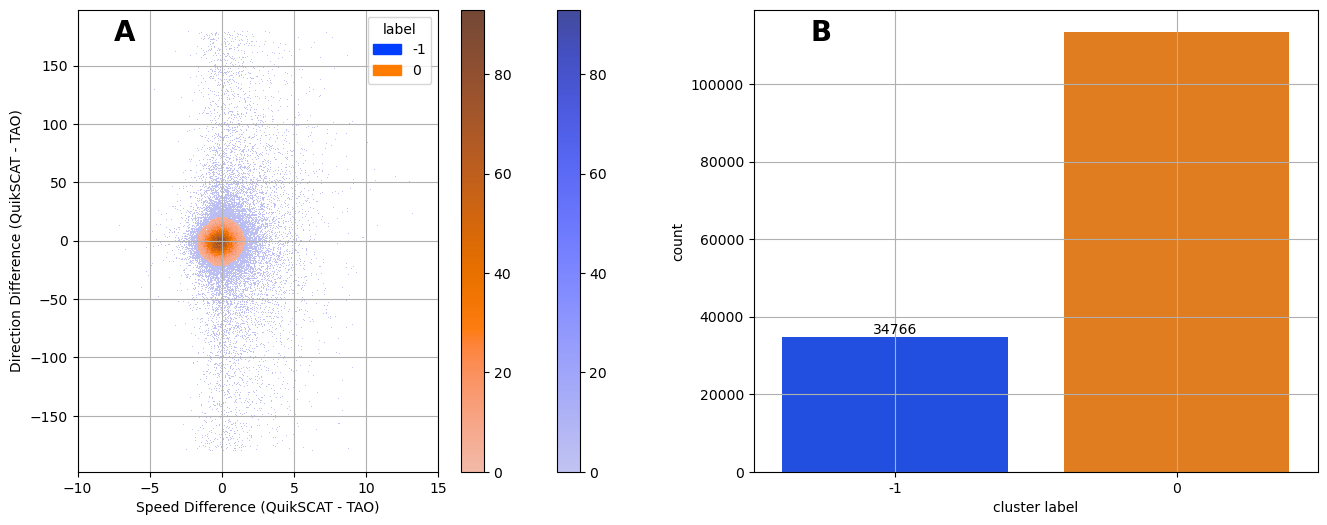

In [3]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [4]:
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

subDF = df.copy()

subDF['norm_xlabel'] = 2 * (subDF[xlabel] - subDF[xlabel].min()) / (subDF[xlabel].max() - subDF[xlabel].min()) - 1
subDF['norm_ylabel'] = 2 * (subDF[ylabel] - subDF[ylabel].min()) / (subDF[ylabel].max() - subDF[ylabel].min()) - 1

subDF['norm_xlabel'] = (subDF['norm_xlabel'] - subDF['norm_xlabel'].mean() + 0.01) #/ (subDF['norm_xlabel'].std())
subDF['norm_ylabel'] = (subDF['norm_ylabel'] - subDF['norm_ylabel'].mean()) #/ (subDF['norm_ylabel'].std())

# subDF['norm_xlabel'] = (subDF[xlabel] - subDF[xlabel].mean()) / (subDF[xlabel].std())
# subDF['norm_ylabel'] = (subDF[ylabel] - subDF[ylabel].mean()) / (subDF[ylabel].std())

# subDF['norm_xlabel'] = 2 * (subDF['norm_xlabel'] - subDF['norm_xlabel'].min()) / (subDF['norm_xlabel'].max() - subDF['norm_xlabel'].min()) - 1
# subDF['norm_ylabel'] = 2 * (subDF['norm_ylabel'] - subDF['norm_ylabel'].min()) / (subDF['norm_ylabel'].max() - subDF['norm_ylabel'].min()) - 1

subDF['theta'] = np.rad2deg(np.arctan2(subDF['norm_ylabel'], subDF['norm_xlabel']))
subDF['r'] = np.sqrt(subDF['norm_ylabel']**2 + subDF['norm_xlabel']**2)

subDF['org_theta'] = np.rad2deg(np.arctan2(subDF[ylabel], subDF[xlabel]))
subDF['org_r'] = np.sqrt(subDF[ylabel]**2 + subDF[xlabel]**2)

# df['theta'] = np.rad2deg(np.arctan2(df[ylabel], df[xlabel]))
# df['r'] = np.sqrt(df[ylabel]**2 + df[xlabel]**2)

# Define bin edges using NumPy (0 to 360 in 0.25° steps)
num_bins = 360*6
bin_edges = np.linspace(0, 360, num_bins, endpoint = False)  # 1441 edges for 1440 bins
right_edges = np.roll(bin_edges, -1)
right_edges[-1] = 360
bin_centers = (bin_edges + right_edges)/2
# Digitize theta into bins
subDF['org_theta_bin'] = np.digitize((subDF['org_theta'] + 360)% 360, bins=bin_edges, right=False)
subDF['org_theta_bin'] = subDF['org_theta_bin'] % num_bins  # Ensure cyclic wrap-around


subDF['theta_bin'] = np.digitize((subDF['theta'] +360) % 360, bins=bin_edges, right=False)
subDF['theta_bin'] = subDF['theta_bin'] % num_bins  # Ensure cyclic wrap-around

ssubDF = subDF.loc[df['label'] == 0]

In [5]:
bin_centers

array([8.33333333e-02, 2.50000000e-01, 4.16666667e-01, ...,
       3.59583333e+02, 3.59750000e+02, 3.59916667e+02], shape=(2160,))

In [6]:
np.max(subDF['org_theta_bin'])

np.int64(2159)

In [7]:
maxr = []
minr = []
for i in range(num_bins):
    thisDF = ssubDF.loc[ssubDF['org_theta_bin'] == i]
    maxr.append(np.max(thisDF['org_r']))
    minr.append(np.min(thisDF['org_r']))

[]

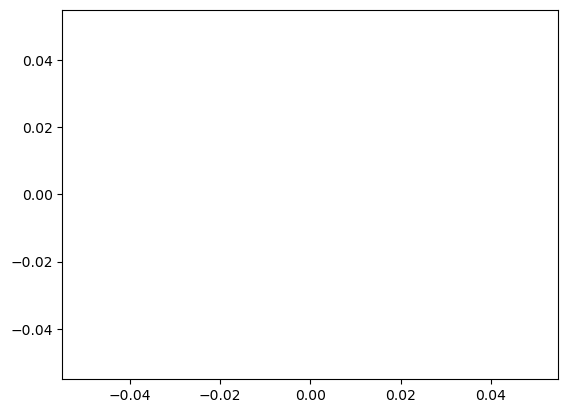

In [8]:
maxr = np.array(maxr)

plt.plot()

In [9]:
def isInsideEllipse(x, y, a, b, x1, y1):
    LHS = ((x - x1)**2)/a**2 + ((y-y1)**2)/b**2
    labels = np.array(LHS < 1, dtype=int)
    return labels

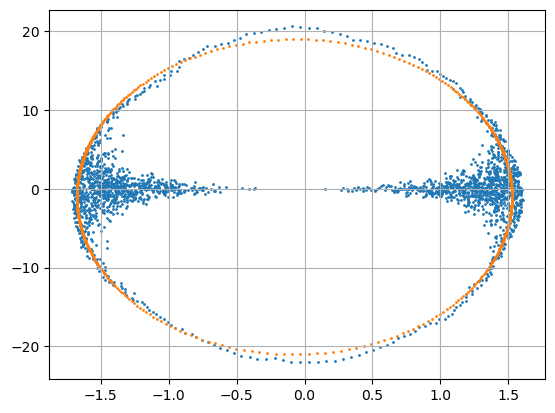

In [10]:
a = 1.6
b = 20
x1 = -0.075
y1 = -1

A = b**2 * np.cos(np.deg2rad(bin_centers))**2 +  a**2 * np.sin(np.deg2rad(bin_centers))**2
B = -2 * (x1 * np.cos(np.deg2rad(bin_centers)) * b**2 + y1 * np.sin(np.deg2rad(bin_centers)) * a**2 )  
C = x1**2* b**2 + y1**2 * a**2 - a**2 * b**2

r1 = (-B + np.sqrt(B**2 - 4* A * C))/(2* A)
#r2 = (-B - np.sqrt(B**2 - 4* A * C))/(2* A)

r = np.sqrt(a **2 * b**2 /(a**2 * np.sin(np.deg2rad(bin_centers))**2 + b**2 * np.cos(np.deg2rad(bin_centers))**2))
plt.scatter(maxr * np.cos(np.deg2rad(bin_centers)), maxr * np.sin(np.deg2rad(bin_centers)), s = 1)
#plt.scatter(r2 * np.cos(np.deg2rad(bin_centers)), r2 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.scatter(r1 * np.cos(np.deg2rad(bin_centers)), r1 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.grid()

In [11]:
ellipseLabel = isInsideEllipse(df[xlabel].to_numpy(), df[ylabel].to_numpy(), a, b, x1, y1)
subDF['ellipseLabel'] = ellipseLabel

/tmp/ipykernel_1374354/667613468.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1374354/667613468.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1374354/667613468.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


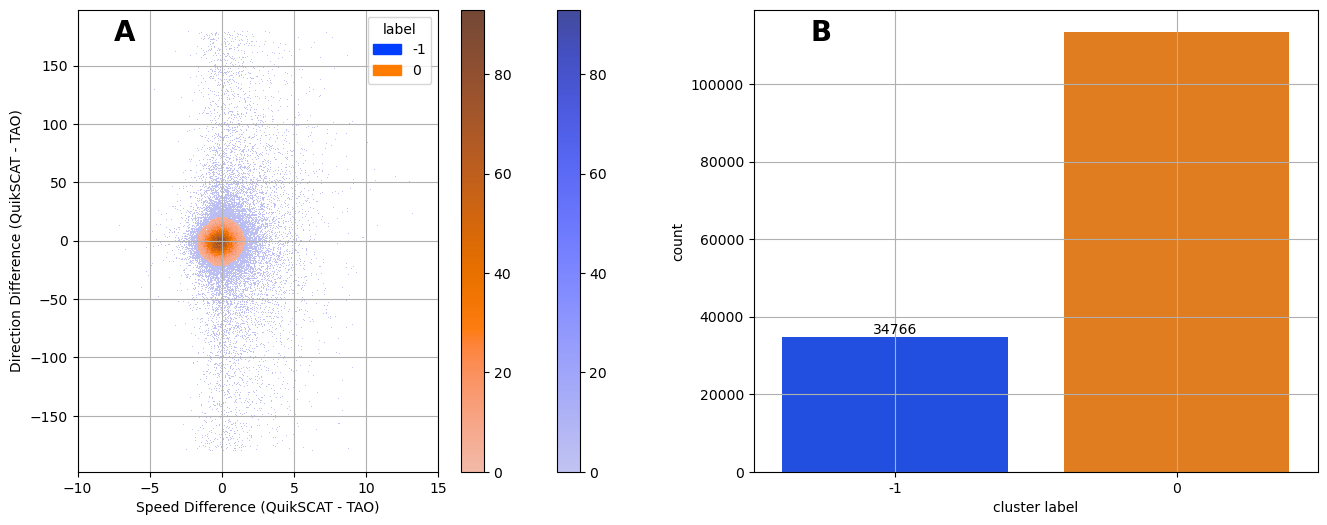

In [12]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


/tmp/ipykernel_1374354/3754269681.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1374354/3754269681.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1374354/3754269681.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


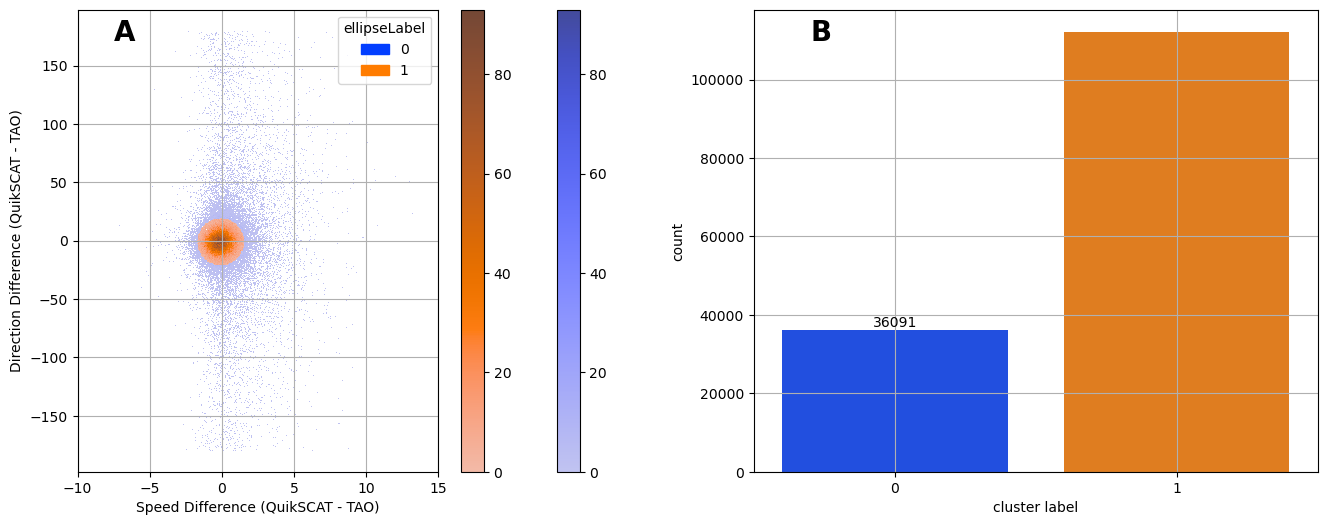

In [13]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='ellipseLabel', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


In [14]:
print(np.min(subDF['norm_xlabel']), np.max(subDF['norm_xlabel']))
print(np.min(subDF['norm_ylabel']), np.max(subDF['norm_ylabel']))
print(np.min(ssubDF['r']), np.max(ssubDF['r']))
print(np.min(subDF['r']), np.max(subDF['r']))

-0.6160218414343746 1.3839781585656254
-0.9982810103075032 1.001718989692497
0.00011599063287677908 0.13954560704314503
0.00011599063287677908 1.5756402999746013


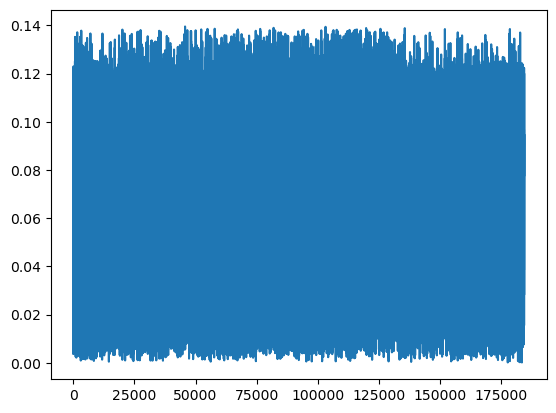

In [15]:
plt.plot(ssubDF['r'])

In [16]:
ssubDF = subDF.loc[np.logical_and(subDF['r'].to_numpy() > 0.11, subDF['r'].to_numpy() < 0.16)]

/tmp/ipykernel_1374354/2357187042.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(ssubDF, x=xlabel, y = ylabel, #levels=10,
/tmp/ipykernel_1374354/2357187042.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_1374354/2357187042.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

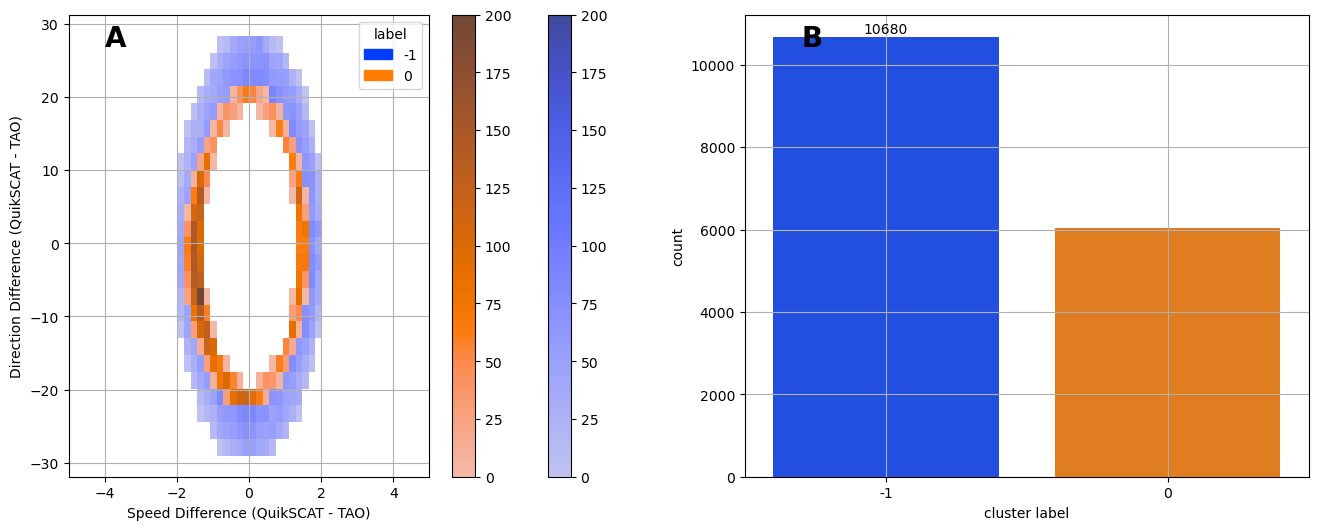

In [17]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(ssubDF, x=xlabel, y = ylabel, #levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-5,5)

ax = axes[1]
s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [18]:
mask = np.logical_and(subDF['r'].to_numpy() > 0.09, subDF['r'].to_numpy() < 0.17)
subDF = subDF.loc[~mask]

In [19]:
subDF['SST-AIRT'] = subDF['Sea Surface Temperature (TAO)'] - subDF['Air Temperature (TAO)']

In [20]:
list(subDF.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_RELH',
 'std_RELH',
 'mean_U10N_x',
 'std_U10N_x',
 'mean_U10N_y',
 'std_U10N_y',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'LATITUDE',
 'LONGITUDE',
 'TAO_TIME',
 'Deployment index',
 'Wind Speed (QuikSCAT)',
 'Wind Direction (QuikSCAT)',
 'rain_impact',
 'flags',
 'eflags',
 'nudge_wind_speed',
 'nudge_wind_direction',
 'retrieved_wind_speed_uncorrected',
 'cross_track_wind_speed_bias',
 'atmospheric_speed_bias',
 'wind_obj',
 'ambigu

In [21]:
subDF['label'] = subDF['label'].apply(lambda x: 1 if x == 0 else 0)

# Features to use for classification
features = ['std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'mean_SST - AIRT',
            'std_SST - AIRT', 
            'Relative Humidity (TAO)',             
            'mean_RELH',             
            'mean_SST',
            'std_AIRT',
            'std_SST', 
            'mean_AIRT',
            'std_RELH',
            'Neutral Wind Speed at 10m (TAO)',
            'std_WSPD', 
            'mean_WSPD',
            'mean_WSPD_10N',
            'std_WSPD_10N',
           ]

# Split the dataset into features (X) and target (y)
X = subDF[features]
y = subDF['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Initialize and train a RandomForest Classifier
classifier = RandomForestClassifier(n_estimators=200,
                                    max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    bootstrap=True,
                                    random_state=42,
                                    class_weight='balanced',
                                    n_jobs=-1)
classifier.fit(X_train_bal, y_train_bal)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_train_bal, y_train_bal))
print("\nClassification Report:\n", classification_report(y_train_bal, y_train_bal))

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     75051
           1       1.00      1.00      1.00     75051

    accuracy                           1.00    150102
   macro avg       1.00      1.00      1.00    150102
weighted avg       1.00      1.00      1.00    150102

Accuracy: 0.898414613131139

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76      4554
           1       0.96      0.92      0.94     18658

    accuracy                           0.90     23212
   macro avg       0.83      0.87      0.85     23212
weighted avg       0.91      0.90      0.90     23212



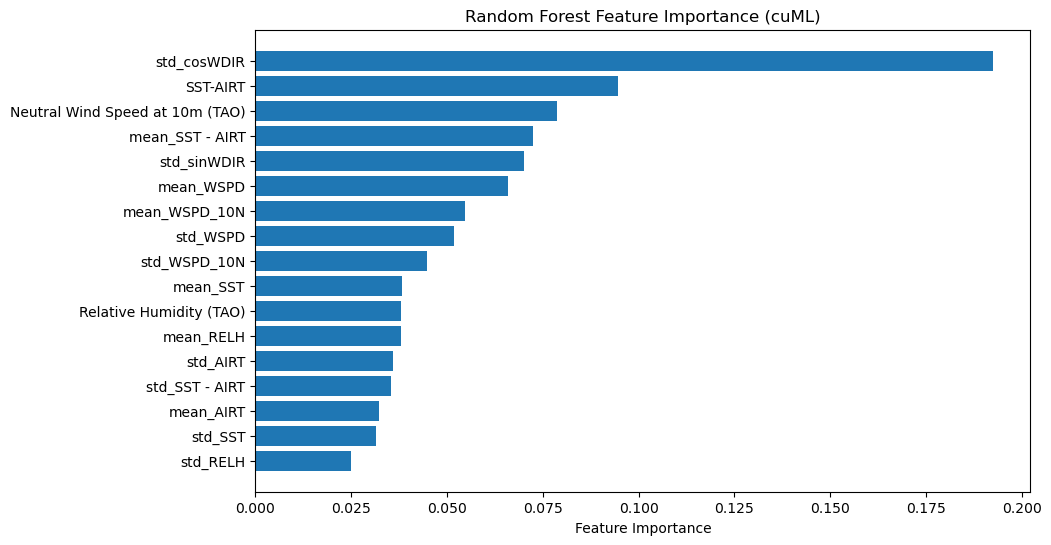

In [22]:
#importances = best_model.feature_importances_
importances = classifier.feature_importances_

# Feature names (must match your input order)
feature_names = X_train.columns  

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (cuML)')
plt.gca().invert_yaxis()  # Most important at top

In [23]:
import joblib

joblib.dump(classifier, "random_forest_goodBadMatchup.joblib")

# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

['random_forest_goodBadMatchup.joblib']

/tmp/ipykernel_1374354/4268395156.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df.loc[df['label'] == -1], x=xlabel, y = ylabel, bins=1000,


(-3.0, 3.0)

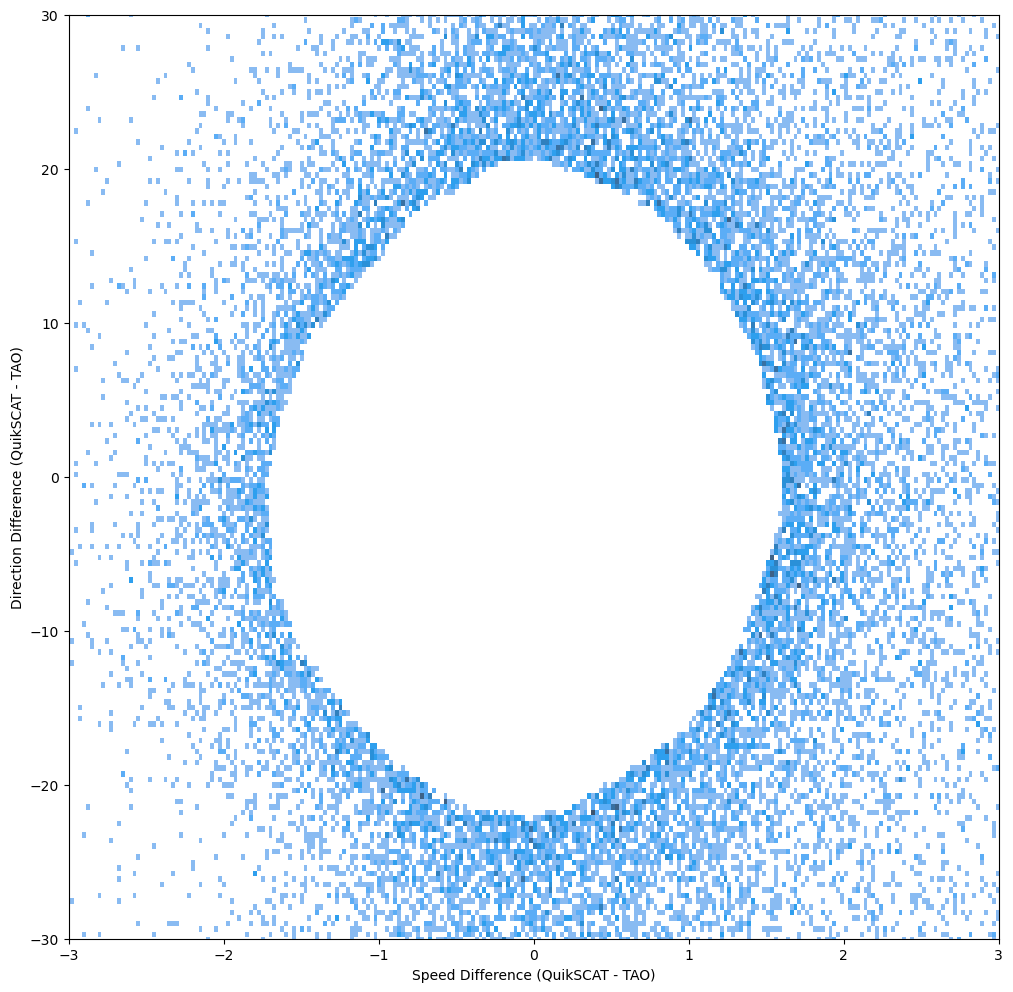

In [24]:
fig, ax = plt.subplots(figsize=(12,12))
sns.histplot(df.loc[df['label'] == -1], x=xlabel, y = ylabel, bins=1000, 
            #hue='label', common_norm=True, cbar = True,
            palette = sns.color_palette("bright"), ax = ax)
ax.set_ylim([-30,30])
ax.set_xlim([-3,3])

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Features and Target
features = ['std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'mean_SST - AIRT',
            'std_SST - AIRT', 
            'Relative Humidity (TAO)',             
            'mean_RELH',             
            'mean_SST',
            'std_AIRT',
            'std_SST', 
            'mean_AIRT',
            'std_RELH',
            'Neutral Wind Speed at 10m (TAO)',
            'std_WSPD', 
            'mean_WSPD',
            'mean_WSPD_10N',
            'std_WSPD_10N']

X = subDF[features].values
#y = subDF['ellipseLabel'].values
y = subDF['label'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE for Class Balancing
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

# Build the Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_bal.shape[1],)),
    #Dropout(0.3),
    Dense(16, activation='relu'),
    #Dropout(0.2),
    Dense(128, activation='relu'),
    #Dropout(0.2),
    Dense(16, activation='relu'),  
    #Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to Prevent Overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train_bal, y_train_bal, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=256, 
                    callbacks=[early_stop],
                    verbose=1)

#plot_training_curves(history)

# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


2025-05-16 14:08:54.096007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 14:08:54.107627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747418934.120400 1374354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747418934.124078 1374354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747418934.133478 1374354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/100


I0000 00:00:1747418937.371258 1375051 service.cc:152] XLA service 0x7fb0d00067d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747418937.371290 1375051 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-05-16 14:08:57.415598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747418937.601946 1375051 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-16 14:09:00.001038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_472', 88 bytes spill stores, 88 bytes spill loads



 38/470 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7703 - loss: 0.5863

I0000 00:00:1747418942.055789 1375051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


465/470 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8456 - loss: 0.3938

2025-05-16 14:09:06.164297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_195', 4 bytes spill stores, 4 bytes spill loads



470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8457 - loss: 0.3934

2025-05-16 14:09:09.042074: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_38', 8 bytes spill stores, 8 bytes spill loads

2025-05-16 14:09:09.246410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads



470/470 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8458 - loss: 0.3933 - val_accuracy: 0.7963 - val_loss: 0.4636
Epoch 2/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8663 - loss: 0.3266 - val_accuracy: 0.8035 - val_loss: 0.4521
Epoch 3/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8721 - loss: 0.3135 - val_accuracy: 0.8045 - val_loss: 0.4537
Epoch 4/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8724 - loss: 0.3087 - val_accuracy: 0.8210 - val_loss: 0.4164
Epoch 5/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8738 - loss: 0.3052 - val_accuracy: 0.8359 - val_loss: 0.3805
Epoch 6/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8749 - loss: 0.3036 - val_accuracy: 0.8034 - val_loss: 0.4749
Epoch 7/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8778 - loss: 0.2988 - val_accuracy: 0.8121 - val_loss: 0.4177
Epoch 8/100
470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8780 - loss: 0.2973 - val_accuracy: 0.81

2025-05-16 14:10:24.939325: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 4 bytes spill stores, 4 bytes spill loads



705/726 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-05-16 14:10:28.374165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 12 bytes spill stores, 12 bytes spill loads



726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Training Accuracy (Last Epoch): 0.8900575637817383

Test Accuracy: 0.8784680337756333

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73      4554
           1       0.95      0.89      0.92     18658

    accuracy                           0.88     23212
   macro avg       0.80      0.86      0.82     23212
weighted avg       0.89      0.88      0.88     23212



In [26]:
# Save
np.save('X_train.npy', X_train)

In [27]:
# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.25).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training Accuracy (Last Epoch): 0.8900575637817383

Test Accuracy: 0.9008702395312769

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.74      4554
           1       0.93      0.95      0.94     18658

    accuracy                           0.90     23212
   macro avg       0.85      0.83      0.84     23212
weighted avg       0.90      0.90      0.90     23212



In [28]:
model.save('my_tf_model.h5')     # TensorFlow SavedModel format (folder)

In [29]:
# import keras_tuner as kt  # If you're using Keras Tuner v1.x
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# input_dim = X_train_bal.shape[1]

# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('units_input', 16, 128, step=16), activation='relu', input_shape=(input_dim,)))
#     model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))

#     for i in range(hp.Int('num_layers', 1, 3)):
#         model.add(Dense(hp.Int(f'units_{i}', 16, 128, step=16), activation='relu'))
#         model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='LOG')),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='tuner_dir',
#     project_name='wind_matchup_tuning'
# )

# tuner.search(X_train_bal, y_train_bal,
#              validation_split=0.2,
#              epochs=50,
#              batch_size=256,
#              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# # Get best model
# best_model = tuner.get_best_models(1)[0]
# best_model.evaluate(X_test, y_test)


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Print all selected hyperparameter values
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the full summary of trials as a DataFrame
tuner_results = tuner.oracle.get_best_trials(num_trials=10)
results_data = []

for trial in tuner_results:
    trial_summary = trial.metrics.get_last_value('val_accuracy')
    trial_params = trial.hyperparameters.values
    trial_params['val_accuracy'] = trial_summary
    results_data.append(trial_params)

results_df = pd.DataFrame(results_data)

# Plot Validation Accuracy vs. Number of Neurons in Input Layer
plt.figure(figsize=(8, 5))
plt.scatter(results_df['units_input'], results_df['val_accuracy'], c='blue')
plt.xlabel('Neurons in Input Layer')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Input Layer Size')
plt.grid(True)
plt.show()

# Plot Validation Accuracy vs. Learning Rate
plt.figure(figsize=(8, 5))
plt.scatter(results_df['lr'], results_df['val_accuracy'], c='green')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()

# If you want to explore the DataFrame directly
print(results_df.sort_values(by='val_accuracy', ascending=False))


In [ ]:
# Predictions
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))